# Import Libraries

In [ ]:
from scipy.io import loadmat
import optuna
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from skimage.feature import canny
import numpy as np
from skimage.filters import sobel, prewitt, roberts, laplace
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import matplotlib.pyplot as plt

# Import Data 

In [ ]:
data = loadmat(r'C:\Users\loren\Documents\computer_vision\assigment\Data\Raw\Brain.mat')  
T1 = data['T1'] 
T1_label = data['label']
print(f"T1 shape: {T1.shape}, Label shape: {T1_label.shape}")

T1 shape: (362, 434, 10), Label shape: (362, 434, 10)


In [ ]:
# QuantileTransformer-based outlier removal
def remove_outliers_with_quantile_transformer(data, lower_percentile=2, upper_percentile=98):
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return np.clip(data, lower_bound, upper_bound)
# Normalize the entire MRI volume
T1_normalized = (T1 - T1.min()) / (T1.max() - T1.min())

# Modelling

In [ ]:
# Define transformations
transformations = {
    "sobel": sobel,
    "prewitt": prewitt,
    "roberts": roberts,
    "laplace": laplace,
    "canny": canny
}
# Define the objective function for Optuna
def objective(trial):
    # Sample parameters using Optuna
    n_clusters = trial.suggest_int('n_clusters', 6, 7)  # Choose between 6 and 7 clusters
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    transformation_name = trial.suggest_categorical('transformation', list(transformations.keys()))
    sigma = trial.suggest_float('sigma', 0.01, 2.0, log=True)  # Sigma in a log scale
    scaler_choice = trial.suggest_categorical('scaler', ['standard', 'minmax', 'quantile'])
    # Select the scaler
    if scaler_choice == 'standard':
        scaler = StandardScaler()
    elif scaler_choice == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_choice == 'quantile':
        scaler = QuantileTransformer(output_distribution='uniform')

    total_f1_score = 0

    # Iterate through slices
    for slice_index in range(T1.shape[2]):
        mri_slice = T1_normalized[:, :, slice_index]
        ground_truth = T1_label[:, :, slice_index]
        # Remove outliers
        mri_slice_cleaned = remove_outliers_with_quantile_transformer(mri_slice)
        # Apply Gaussian smoothing
        smoothed_slice = gaussian_filter(mri_slice_cleaned, sigma=sigma)
        # Apply transformation
        transformed_image = transformations[transformation_name](smoothed_slice)
        # Combine features
        intensity_flat = smoothed_slice.flatten().reshape(-1, 1)
        edges_flat = transformed_image.flatten().reshape(-1, 1)
        features = np.concatenate([intensity_flat, edges_flat], axis=1)
        # Normalize features
        features_scaled = scaler.fit_transform(features)
        # Apply K-Means
        kmeans = KMeans(n_clusters=n_clusters, init=init, random_state=42)
        clusters = kmeans.fit_predict(features_scaled)
        segmented_image = clusters.reshape(mri_slice.shape)
        # Calculate F1 Score for each cluster
        slice_f1_scores = []
        for cluster_id in range(n_clusters):
            cluster_mask = (segmented_image == cluster_id).astype(int)
            ground_truth_mask = (ground_truth == cluster_id).astype(int)

            if np.any(ground_truth_mask):
                f1 = f1_score(ground_truth_mask.flatten(), cluster_mask.flatten(), average='weighted')
            else:
                f1 = 0.0
            slice_f1_scores.append(f1)
        # Average F1 Score for the current slice
        slice_score = np.mean(slice_f1_scores)
        total_f1_score += slice_score
    # Average F1 Score across all slices
    average_f1_score = total_f1_score / T1.shape[2]
    return average_f1_score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)  # Adjust n_trials for the search space size
# Print the best parameters and score
print("Best Parameters:", study.best_params)
print("Best F1 Score:", study.best_value)


# Prediction


Best Parameters: {'n_clusters': 6, 'init': 'random', 'transformation': 'sobel', 'sigma': 0.1477146179304404, 'scaler': 'quantile'}
Best Average F1 Score Across All Slices: 0.7902906474804396


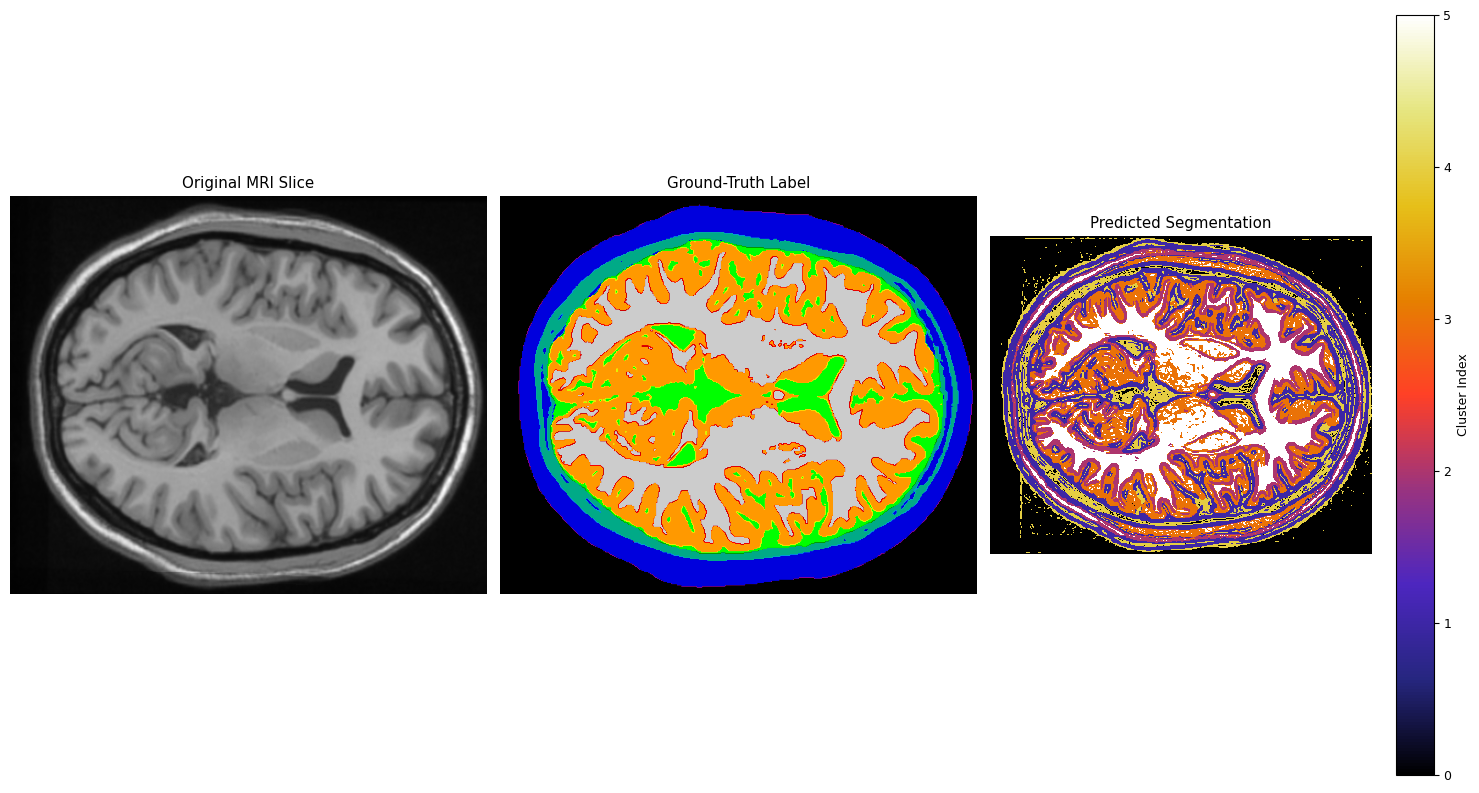

In [ ]:
# Output the best parameters and score
print("\nBest Parameters:", study.best_params)
print("Best Average F1 Score Across All Slices:", study.best_value)

# Visualize results for a single slice using the best parameters
best_sigma = study.best_params['sigma']
best_transformation = study.best_params['transformation']
best_n_clusters = study.best_params['n_clusters']
best_init = study.best_params['init']
scaler_mapping = {
	'standard': StandardScaler(),
	'minmax': MinMaxScaler(),
	'quantile': QuantileTransformer(output_distribution='uniform')
}
best_scaler = scaler_mapping[study.best_params['scaler']]

# Select a slice for visualization
visualize_index = 5  # Change this to visualize a different slice
mri_slice = T1_normalized[:, :, visualize_index]
ground_truth = T1_label[:, :, visualize_index]
# Remove outliers
mri_slice_cleaned = remove_outliers_with_quantile_transformer(mri_slice)
# Apply Gaussian smoothing
best_smoothed_slice = gaussian_filter(mri_slice_cleaned, sigma=best_sigma)
# Apply the best transformation
best_transformed_image = transformations[best_transformation](best_smoothed_slice)
# Combine features
intensity_flat = best_smoothed_slice.flatten().reshape(-1, 1)
edges_flat = best_transformed_image.flatten().reshape(-1, 1)
features = np.concatenate([intensity_flat, edges_flat], axis=1)
# Normalize features
features_scaled = best_scaler.fit_transform(features)
# Apply K-Means
kmeans = KMeans(n_clusters=best_n_clusters, init=best_init, random_state=42)
kmeans.fit(features_scaled)
clusters = kmeans.predict(features_scaled)
segmented_image = clusters.reshape(mri_slice.shape)

# Visualization
plt.figure(figsize=(15, 8))
# Original MRI slice
plt.subplot(1, 3, 1)
plt.imshow(mri_slice, cmap='gray')
plt.title("Original MRI Slice")
plt.axis('off')
# Ground-Truth Label
plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='nipy_spectral')
plt.title("Ground-Truth Label")
plt.axis('off')
# Predicted Segmentation
plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='CMRmap', interpolation='none')
plt.title("Predicted Segmentation")
plt.axis('off')
plt.colorbar(label="Cluster Index")

plt.tight_layout()
plt.show()

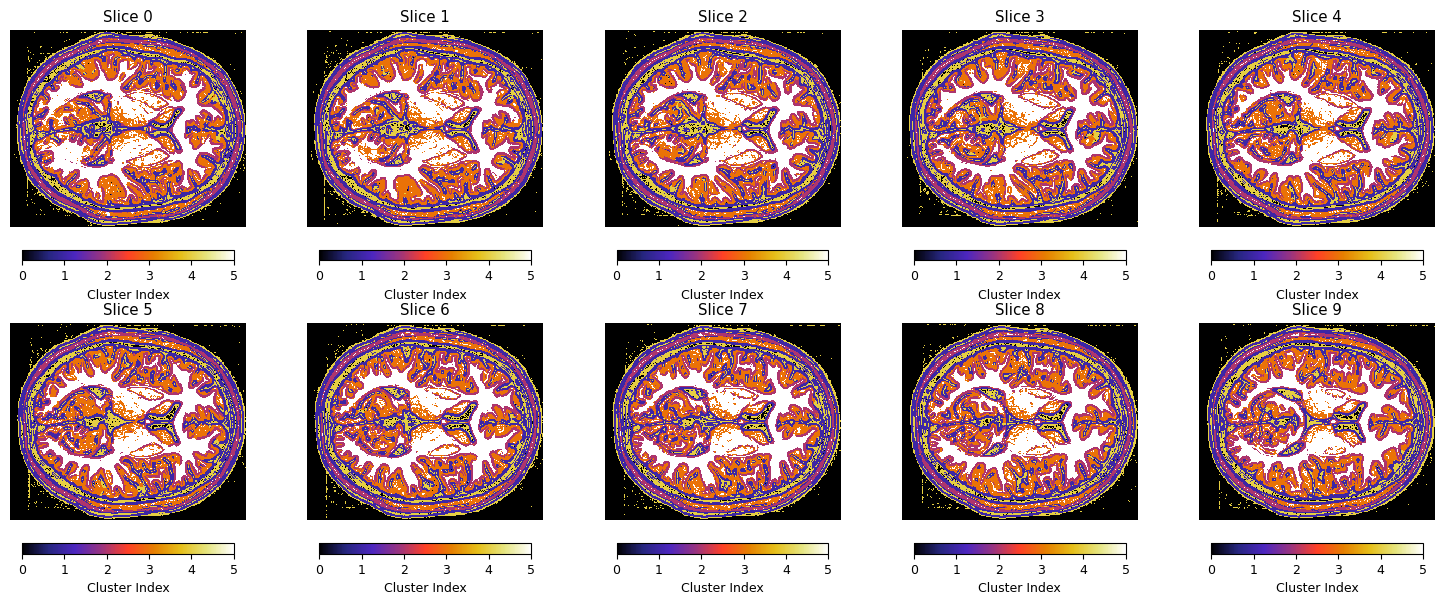

In [ ]:
# Visualize predictions for all slices
def visualize_all_predictions(T1_normalized, label, predictions):
    num_slices = T1_normalized.shape[2]
    cols = 5  # Number of columns in the grid
    rows = (num_slices // cols) + (num_slices % cols > 0)  # Calculate the required rows

    plt.figure(figsize=(15, rows * 3))

    for i in range(num_slices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(predictions[i], cmap='CMRmap', interpolation='none')
        plt.title(f"Slice {i}")
        plt.colorbar(label="Cluster Index", fraction=0.046, pad=0.1, orientation='horizontal')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate predictions for all slices
predictions = []
for slice_index in range(T1.shape[2]):
    mri_slice = T1_normalized[:, :, slice_index]
    # Apply Gaussian smoothing and transformation
    smoothed_slice = gaussian_filter(mri_slice, sigma=best_sigma)
    transformed_image = transformations[best_transformation](smoothed_slice)
    # Combine features
    intensity_flat = smoothed_slice.flatten().reshape(-1, 1)
    edges_flat = transformed_image.flatten().reshape(-1, 1)
    features = np.concatenate([intensity_flat, edges_flat], axis=1)
    # Normalize features
    features_scaled = best_scaler.transform(features)
    # Predict clusters
    clusters = kmeans.predict(features_scaled)
    segmented_image = clusters.reshape(mri_slice.shape)
    predictions.append(segmented_image)

# Visualize all slices with predictions
visualize_all_predictions(T1_normalized, T1_label, predictions)